## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [12]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

!pip3 install gdown


import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-

but Gdown can't. Please check connections and permissions.

In [4]:
!pip install lightfm

In [5]:
!pip install implicit

In [6]:
!pip install shap

In [8]:
!pip install torch xgboost -q

In [67]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import ndcg_score, log_loss
from sklearn.preprocessing import LabelEncoder
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from lightfm import LightFM
from lightfm.data import Dataset
from implicit.als import AlternatingLeastSquares 
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import chain
import xgboost as xgb
import shap

In [14]:
import pandas as pd
pd.read_csv('users.csv')

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0




### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



In [15]:
df_train = pd.read_csv("D:\\загрузки с браузера\\train_part.csv")
df_test = pd.read_csv("D:\\загрузки с браузера\\test_part.csv")
df_users = pd.read_csv("D:\\загрузки с браузера\\users.csv")
df_items = pd.read_csv("D:\\загрузки с браузера\\items.csv")

In [16]:
df_train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,952323,15997,2021-03-13,7507,100.0,1
2,889459,11460,2021-03-13,60,0.0,0
3,854016,11237,2021-03-13,5381,98.0,1
4,307257,9132,2021-03-13,5814,100.0,1


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4866956 entries, 0 to 4866955
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
 5   target         int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 222.8+ MB


In [18]:
df_test.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608467 entries, 0 to 608466
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        608467 non-null  int64  
 1   item_id        608467 non-null  int64  
 2   last_watch_dt  608467 non-null  object 
 3   total_dur      608467 non-null  int64  
 4   watched_pct    608467 non-null  float64
 5   target         608467 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 27.9+ MB


In [20]:
df_users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [21]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [22]:
df_items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [23]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


In [24]:
# Раздробление данных и перевод в datetime
df_train['last_watch_dt'] = pd.to_datetime(df_train['last_watch_dt'])
df_test['last_watch_dt'] = pd.to_datetime(df_test['last_watch_dt'])

split = df_train['last_watch_dt'].quantile(0.8)
train_stage_1 = df_train[df_train['last_watch_dt'] <= split]
valid_stage_1 = df_train[df_train['last_watch_dt'] > split]

print(f"shape train: {train_stage_1.shape}")
print(f"shape valid: {valid_stage_1.shape}")

shape train: (3940271, 6)
shape valid: (926685, 6)


In [25]:
# Эувристик модель
class ItemCF:
    def __init__(self, top_k=50, min_similarity=0.1):
        self.top_k = top_k
        self.min_similarity = min_similarity
        self.item_similarity = None
        self.user_item_matrix = None
        self.user_id_to_idx = {}
        self.item_id_to_idx = {}
        self.idx_to_item_id = {}

    def fit(self, df_train):
        unique_users = df_train['user_id'].unique()
        unique_items = df_train['item_id'].unique()

        self.user_id_to_idx = {u: i for i, u in enumerate(unique_users)}
        self.item_id_to_idx = {i: j for j, i in enumerate(unique_items)}
        self.idx_to_item_id = {v: k for k, v in self.item_id_to_idx.items()}

        rows = df_train['user_id'].map(self.user_id_to_idx)
        cols = df_train['item_id'].map(self.item_id_to_idx)
        data = np.ones(len(df_train))

        self.user_item_matrix = csr_matrix((data, (rows, cols)), shape=(len(unique_users), len(unique_items)))
        self.item_similarity = cosine_similarity(self.user_item_matrix.T)

        np.fill_diagonal(self.item_similarity, 0)
        self.item_similarity[self.item_similarity < self.min_similarity] = 0

    def predict(self, user_id, item_id):
        if (user_id not in self.user_id_to_idx) or (item_id not in self.item_id_to_idx):
            return 0.0

        user_idx = self.user_id_to_idx[user_id]
        item_idx = self.item_id_to_idx[item_id]

        user_items = self.user_item_matrix[user_idx].toarray().flatten()
        relevant_sims = self.item_similarity[item_idx][user_items > 0]
        return np.mean(relevant_sims) if len(relevant_sims) > 0 else 0.0

    def recommend(self, user_id, k=10):
        if user_id not in self.user_id_to_idx:
            return []

        user_idx = self.user_id_to_idx[user_id]
        user_vector = self.user_item_matrix[user_idx].toarray().flatten()
        scores = np.dot(user_vector, self.item_similarity)

        top_k_idx = np.argpartition(-scores, k)[:k]
        top_k_idx = top_k_idx[np.argsort(-scores[top_k_idx])]

        return [self.idx_to_item_id[idx] for idx in top_k_idx if scores[idx] > 0]

my_heuristic_model = ItemCF(top_k=50, min_similarity=0.1)
my_heuristic_model.fit(train_stage_1)

In [26]:
# SVD
class SVD:
    def __init__(self, n_components=50):
        self.n_components = n_components
        self.user_factors = None
        self.item_factors = None
        self.user_ids = None
        self.item_ids = None
        self.global_mean = 0.0
        self.popular_items = None
        self.item_means = None

    def fit(self, df):
        self.global_mean = df['watched_pct'].mean()
        self.popular_items = df['item_id'].value_counts().head(100).index.tolist()
        self.item_means = df.groupby('item_id')['watched_pct'].mean().to_dict()

        # Матрица
        user_ids = df['user_id'].unique()
        item_ids = df['item_id'].unique()

        self.user_ids = {u: i for i, u in enumerate(user_ids)}
        self.item_ids = {i: u for u, i in enumerate(item_ids)}

        self.id_to_user = {v: k for k, v in self.user_ids.items()}
        self.id_to_item = {v: k for k, v in self.item_ids.items()}

        # Разряженная матрица
        rows = df['user_id'].map(self.user_ids)
        cols = df['item_id'].map(self.item_ids)
        values = df['watched_pct'].values

        user_item_matrix = csr_matrix((values, (rows, cols)), shape=(len(user_ids), len(item_ids)))
        U, sigma, Vt = svds(user_item_matrix, k=self.n_components)
        self.user_factors = U @ np.diag(sigma)
        self.item_factors = Vt.T

        user_norms = np.linalg.norm(self.user_factors, axis=1, keepdims=True)
        user_norms[user_norms == 0] = 1
        self.user_factors = self.user_factors / user_norms

        item_norms = np.linalg.norm(self.item_factors, axis=1, keepdims=True)
        item_norms[item_norms == 0] = 1
        self.item_factors = self.item_factors / item_norms

    def predict(self, user_id, item_id):
        user_known = user_id in self.user_ids
        item_known = item_id in self.item_ids

        if user_known and item_known:
            user_idx = self.user_ids[user_id]
            item_idx = self.item_ids[item_id]
            return np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        elif item_known:
            return self.item_means.get(item_id, self.global_mean)
        else:
            return self.global_mean

    def recommend(self, user_id, k=100):
        if user_id not in self.user_ids:
            return self.popular_items[:k]

        user_idx = self.user_ids[user_id]
        user_factor = self.user_factors[user_idx]

        scores = np.dot(self.item_factors, user_factor)
        top_k_indices = np.argsort(scores)[-k:][::-1]
        return [self.id_to_item[i] for i in top_k_indices if i in self.id_to_item]

In [27]:
my_matrix_factorization = SVD(n_components=50)
my_matrix_factorization.fit(train_stage_1)

In [28]:
# Нейронка
class NeuralCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(NeuralCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.user_id_to_idx = {}
        self.item_id_to_idx = {}
        self.idx_to_item_id = {}
        self.global_mean = 0.0
        self.popular_items = []

    def id_mapping(self, user_ids, item_ids):
        self.user_id_to_idx = {u: i for i, u in enumerate(user_ids)}
        self.item_id_to_idx = {i: j for j, i in enumerate(item_ids)}
        self.idx_to_item_id = {v: k for k, v in self.item_id_to_idx.items()}

    def cold_start_params(self, df):
        self.global_mean = df['target'].mean()
        self.popular_items = df['item_id'].value_counts().head(100).index.tolist()

    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def predict(self, user_id, item_id):
        user_known = user_id in self.user_id_to_idx
        item_known = item_id in self.item_id_to_idx

        if not user_known or not item_known:
                return self.global_mean

        user_idx = torch.LongTensor([self.user_id_to_idx[user_id]])
        item_idx = torch.LongTensor([self.item_id_to_idx[item_id]])
        with torch.no_grad():
            return self(user_idx, item_idx).item()

    def recommend(self, user_id, k=10):
        if user_id not in self.user_id_to_idx:
                return self.popular_items[:k]

        user_idx = torch.LongTensor([self.user_id_to_idx[user_id]])

        scores = []
        for item_id, item_idx in self.item_id_to_idx.items():
            item_idx_tensor = torch.LongTensor([item_idx])
            with torch.no_grad():
                score = self(user_idx, item_idx_tensor).item()
            scores.append((item_id, score))

        scores.sort(key=lambda x: x[1], reverse=True)
        return [item_id for item_id, score in scores[:k]]

In [29]:
def train_ncf(train_data, num_users, num_items, epochs=5, lr=0.001):
    model = NeuralCF(num_users, num_items)
    unique_users = train_data['user_id'].unique()
    unique_items = train_data['item_id'].unique()
    model.id_mapping(unique_users, unique_items)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    user_tensor = torch.LongTensor(train_data['user_id'].map(model.user_id_to_idx).values)
    item_tensor = torch.LongTensor(train_data['item_id'].map(model.item_id_to_idx).values)
    label_tensor = torch.FloatTensor(train_data['target'].values)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(user_tensor, item_tensor).squeeze()
        loss = criterion(output, label_tensor)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.3f}")

    return model

my_neural_network = train_ncf(train_stage_1, num_users=df_users['user_id'].nunique(), num_items=df_items['item_id'].nunique())

Epoch 1/5, Loss: 0.691
Epoch 2/5, Loss: 0.690
Epoch 3/5, Loss: 0.690
Epoch 4/5, Loss: 0.689
Epoch 5/5, Loss: 0.689


Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [30]:
# Анализ кандидатов
def analyze_candidates(models, user_sample, k=150):
    results = {}
    for model_name, model in models.items():
        recommendations = {}
        for user_id in user_sample:
            recs = model.recommend(user_id, k=k)
            recommendations[user_id] = set(recs)

        results[model_name] = recommendations

    diversity_metrics = {}
    overlap_metrics = {}

    model_names = list(models.keys())

    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            m1, m2 = model_names[i], model_names[j]
            overlaps = []

            for user_id in user_sample:
                rec1 = results[m1][user_id]
                rec2 = results[m2][user_id]
                overlap = len(rec1 & rec2) / k
                overlaps.append(overlap)

            mean_overlap = np.mean(overlaps)
            overlap_metrics[f"{m1}_{m2}"] = mean_overlap

    for model_name in model_names:
        all_recs = set()
        for user_id in user_sample:
            all_recs.update(results[model_name][user_id])

        diversity = len(all_recs) / (len(user_sample) * k)
        diversity_metrics[model_name] = diversity

    return {
        "diversity": diversity_metrics,
        "overlap": overlap_metrics}

In [31]:
models = {
    "item_cf": my_heuristic_model,
    "svd": my_matrix_factorization,
    "neural_cf": my_neural_network}

user_sample = train_stage_1['user_id'].sample(220, random_state=42).values
metrics = analyze_candidates(models, user_sample, k=20)

print("Diversity metrics:", metrics['diversity'])
print("Overlap metrics:", metrics['overlap'])

Diversity metrics: {'item_cf': 0.1565909090909091, 'svd': 0.5454545454545454, 'neural_cf': 0.15227272727272728}
Overlap metrics: {'item_cf_svd': 0.05318181818181818, 'item_cf_neural_cf': 0.0022727272727272726, 'svd_neural_cf': 0.00045454545454545455}



### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [32]:
valid_cut = valid_stage_1['last_watch_dt'].min() - pd.Timedelta(days=1)
test_cut = df_test['last_watch_dt'].min() - pd.Timedelta(days=1)

In [33]:
historical_train = df_train[df_train['last_watch_dt'] <= valid_cut]
historical_test = df_train[df_train['last_watch_dt'] <= test_cut]

In [34]:
historical_train = historical_train.merge(df_users, on='user_id', how='left')
historical_train = historical_train.merge(df_items, on='item_id', how='left')

historical_test = historical_test.merge(df_users, on='user_id', how='left')
historical_test = historical_test.merge(df_items, on='item_id', how='left')

In [35]:
# Генерации признаков
def generate_features(df, historical_data):
    # User
    user_features = historical_data.groupby('user_id')['watched_pct'].agg(['mean', 'count']).reset_index()
    user_features.columns = ['user_id', 'user_avg_watch_prct', 'user_total_watched_items']

    # Item
    item_features = historical_data.groupby('item_id')['watched_pct'].agg(['mean', 'count']).reset_index()
    item_features.columns = ['item_id', 'item_avg_watch_prct', 'item_total_watchers']

    # User-Item
    user_item_features = historical_data.groupby(['user_id', 'item_id'])['watched_pct'].mean().reset_index()
    user_item_features.columns = ['user_id', 'item_id', 'user_item_avg_watch_prct']
    if 'genres' in df_items.columns:
        genre_features = historical_data.groupby(['user_id', 'genres'])['watched_pct'].mean().reset_index()
        genre_features.columns = ['user_id', 'genres', 'user_genre_affinity']
        df = df.merge(df_items[['item_id', 'genres']], on='item_id', how='left')
        df = df.merge(genre_features, on=['user_id', 'genres'], how='left')
        df.drop('genres', axis=1, inplace=True)

    df = df.merge(user_features, on='user_id', how='left')
    df = df.merge(item_features, on='item_id', how='left')
    df = df.merge(user_item_features, on=['user_id', 'item_id'], how='left')

    return df

In [36]:
train_df_features = generate_features(valid_stage_1, historical_train)
test_df_features = generate_features(df_test, historical_test)

In [37]:
train_df_features.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,user_genre_affinity,user_avg_watch_prct,user_total_watched_items,item_avg_watch_prct,item_total_watchers,user_item_avg_watch_prct
0,1038054,12356,2021-07-27,197,4.0,0,NaN,NaN,NaN,63.081042,3492.0,NaN
1,765534,16166,2021-07-27,739,12.0,0,NaN,0.000000,1.0,58.331589,9361.0,NaN
2,799026,14264,2021-07-27,1500,17.0,0,NaN,50.428571,7.0,59.916101,2503.0,NaN
3,297066,16166,2021-07-27,4209,67.0,1,NaN,52.000000,2.0,58.331589,9361.0,NaN
4,1014861,6106,2021-07-27,49790,63.0,1,NaN,76.967742,31.0,29.115684,899.0,NaN


In [38]:
test_df_features.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,user_genre_affinity,user_avg_watch_prct,user_total_watched_items,item_avg_watch_prct,item_total_watchers,user_item_avg_watch_prct
0,718866,6382,2021-08-13,10309,19.0,0,NaN,55.0,2.0,22.855103,4693.0,NaN
1,147119,13865,2021-08-13,1666,26.0,0,NaN,NaN,NaN,68.680699,111863.0,NaN
2,1079425,4141,2021-08-13,774,10.0,0,NaN,37.7,10.0,59.019287,2748.0,NaN
3,810008,15297,2021-08-13,3,0.0,0,NaN,NaN,NaN,55.291089,175307.0,NaN
4,1068123,10440,2021-08-13,492,0.0,0,NaN,NaN,NaN,47.377237,184054.0,NaN



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [39]:
# Добавление скора
def add_scores(df, models):
    for model_name, model in models.items():
        df[f'score_{model_name}'] = df.apply(
            lambda x: model.predict(x['user_id'], x['item_id']),
            axis=1
        )
    return df

train_df_scores = add_scores(train_df_features, models)
test_df_scores = add_scores(test_df_features, models)

In [40]:
cold_users = set(train_df_scores['user_id']) - set(train_df_scores['user_id'])
warm_users = set(train_df_scores['user_id'])

for col in ['user_avg_watch_prct', 'user_total_watched_items']:
    test_df_scores.loc[test_df_scores['user_id'].isin(cold_users), col] = test_df_scores[col].mean()

In [41]:
train_df_scores = train_df_scores.sort_values('user_id')

y_train = train_df_scores['target'].loc[train_df_scores.index]
X_train = train_df_scores.drop(['target', 'user_id', 'item_id', 'last_watch_dt', 'watched_pct'], axis=1).loc[train_df_scores.index]
X_test = test_df_scores.drop(['target', 'user_id', 'item_id', 'last_watch_dt', 'watched_pct'], axis=1)
y_test = test_df_scores['target']

In [42]:
X_train = X_train.fillna(0)

In [43]:
# Classifier
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 500]
}

gs = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic'), params, cv=3, scoring='neg_log_loss')
gs.fit(X_train, y_train)
print(gs.best_params_)

{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}


In [44]:
xgb_class = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.3,
    random_state=42
)

xgb_class.fit(X_train, y_train)
pred_proba = xgb_class.predict_proba(X_test)[:, 1]
print(f"Loss: {log_loss(y_test, pred_proba):.10f}")

Loss: 0.1804153355


Это достаточно низкое значение log_loss, что говорит о хорошем качестве классификации.

In [45]:
# Определение пользовательской метрики
from sklearn.metrics import ndcg_score

def custom_ndcg_scorer(estimator, X, y_true):
    y_pred = estimator.predict(X)
    y_true_reshaped = y_true.reshape(-1, 1)
    y_pred_reshaped = y_pred.reshape(-1, 1)
    return ndcg_score(y_true_reshaped, y_pred_reshaped)

In [46]:
# Группировка данных
group_counts = train_df_scores.groupby('user_id').size()
group_by_instance = np.repeat(np.arange(len(group_counts)), group_counts)
groups = group_counts.values

In [47]:
# Ranker

#cv = GroupKFold(n_splits=3)
#params = {
#    'max_depth': [3, 5, 7],
#    'learning_rate': [0.01, 0.1, 0.3],
#    'n_estimators': [100, 200, 500]
#}

#gs = GridSearchCV(
#    xgb.XGBRanker(objective='rank:pairwise'),
#    params,
#    cv=cv,
#    scoring=custom_ndcg_scorer,
#    error_score='raise'  # Включаем вывод ошибок
#)

# Обучение модели
#fit_params = {'group': groups}
#gs.fit(X_train, y_train, groups=group_by_instance, **fit_params)

#print(gs.best_params_)

In [48]:
# Ranker (настраивал в ручную, с гридсерчем какие-то проблемы, не мгу пофиксить, так бы конечно подбор гиперпараметров был куда лучше, если будет возможность, дайте пожайуйста комментарий по гридсерчу)
# Список конфигураций для ранкеров
ranker_configs = [
    {
        'objective': 'rank:pairwise',
        'eval_metric': 'ndcg@5',
        'n_estimators': 500,
        'max_depth': 6,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    },
    {
        'objective': 'rank:pairwise',
        'eval_metric': 'ndcg@5',
        'n_estimators': 300,
        'max_depth': 4,
        'learning_rate': 0.1,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'random_state': 42
    },
    {
        'objective': 'rank:pairwise',
        'eval_metric': 'ndcg@5',
        'n_estimators': 1000,
        'max_depth': 8,
        'learning_rate': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'random_state': 42
    }
]

In [49]:
# Обучение ранкеров и сохранение их в список
trained_rankers = []
for i, config in enumerate(ranker_configs):
    print(f"Обучение модели {i + 1} с параметрами: {config}")
    ranker = xgb.XGBRanker(**config)
    ranker.fit(X_train, y_train, group=groups)
    trained_rankers.append(ranker)

Обучение модели 1 с параметрами: {'objective': 'rank:pairwise', 'eval_metric': 'ndcg@5', 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42}
Обучение модели 2 с параметрами: {'objective': 'rank:pairwise', 'eval_metric': 'ndcg@5', 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7, 'random_state': 42}
Обучение модели 3 с параметрами: {'objective': 'rank:pairwise', 'eval_metric': 'ndcg@5', 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'subsample': 0.9, 'colsample_bytree': 0.9, 'random_state': 42}


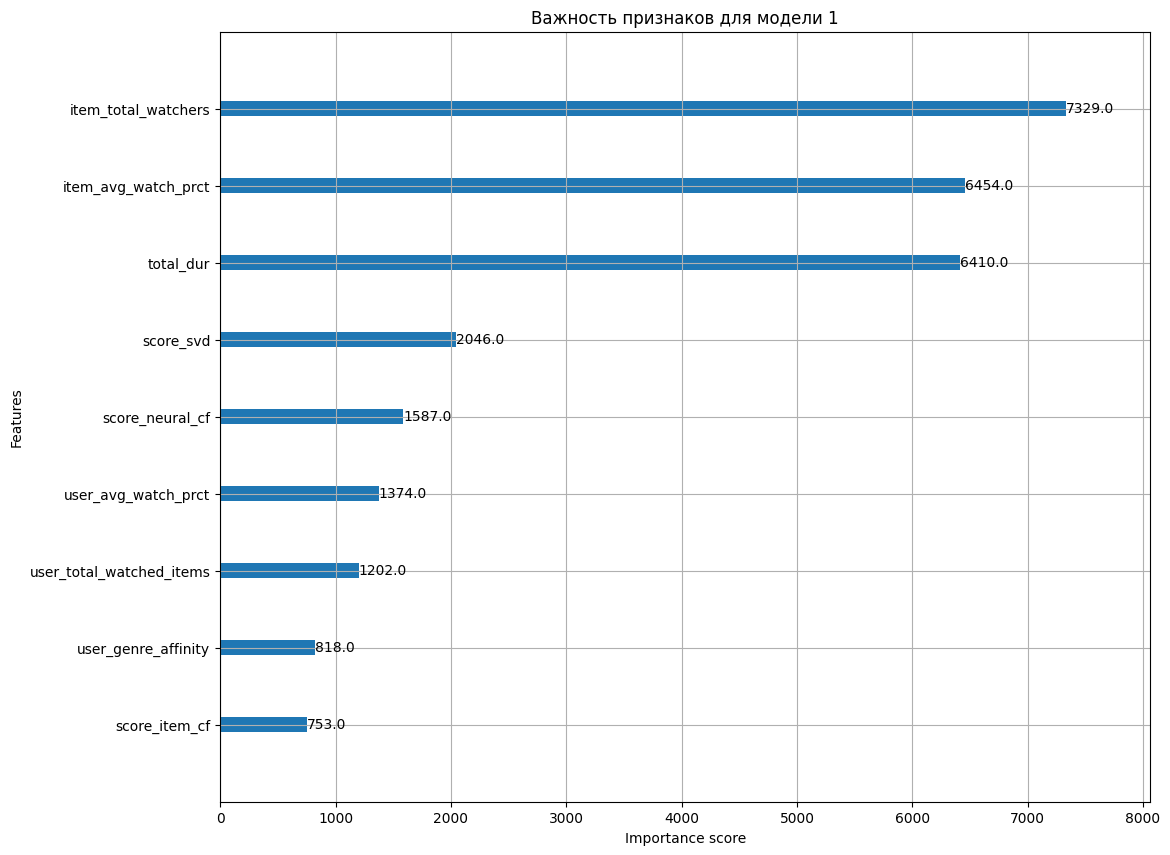

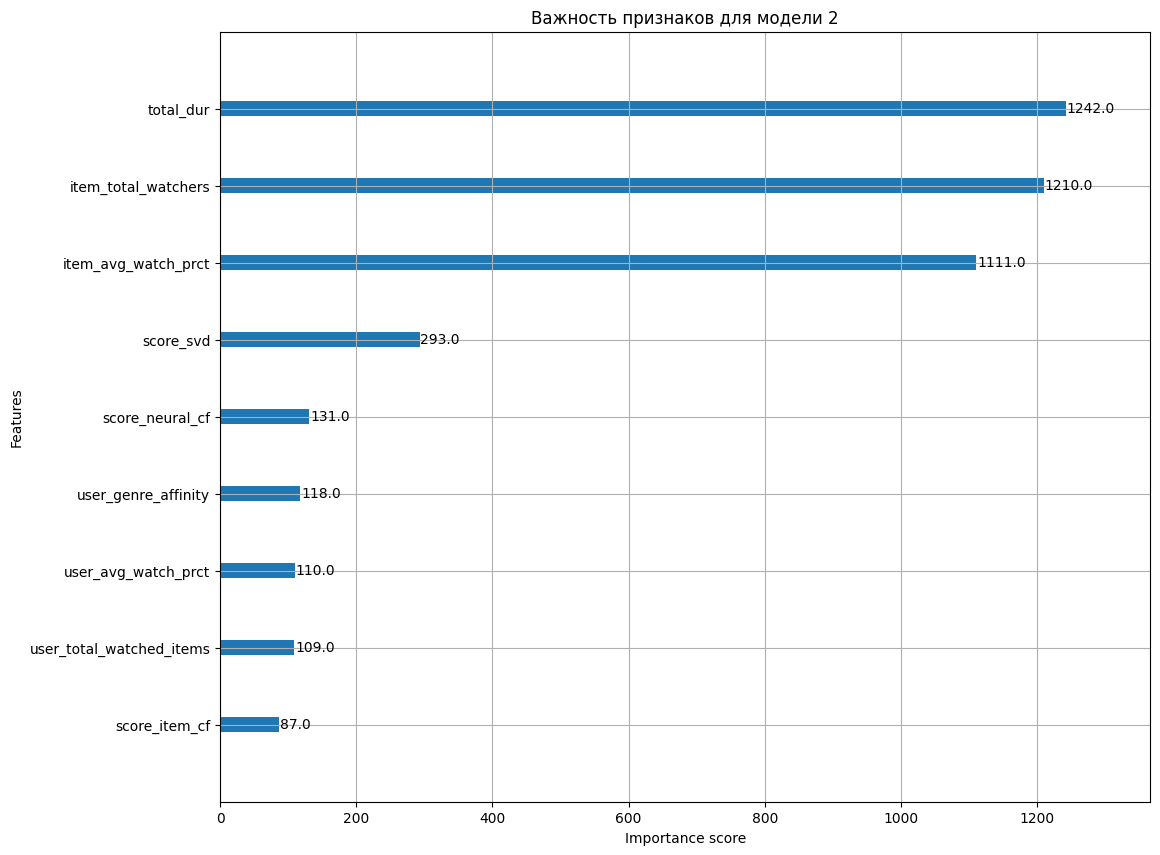

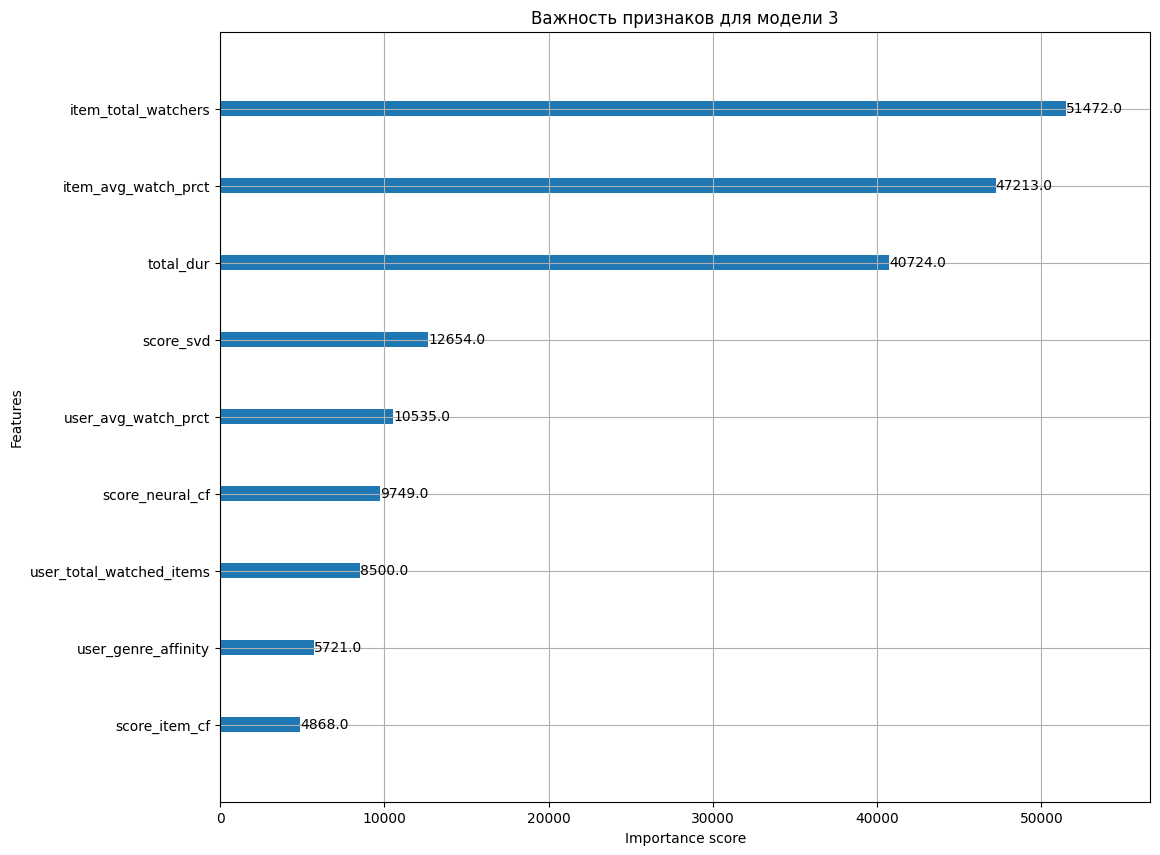

In [50]:
# Визуализация важности признаков для каждой модели
for i, ranker in enumerate(trained_rankers):
    fig, ax = plt.subplots(figsize=(12, 10))
    xgb.plot_importance(ranker, ax=ax, max_num_features=20)
    plt.title(f'Важность признаков для модели {i + 1}')
    plt.show()


по всем трем показателям самые важные признаки это total_dur, item_total_watchers, item_avg_watch_prct

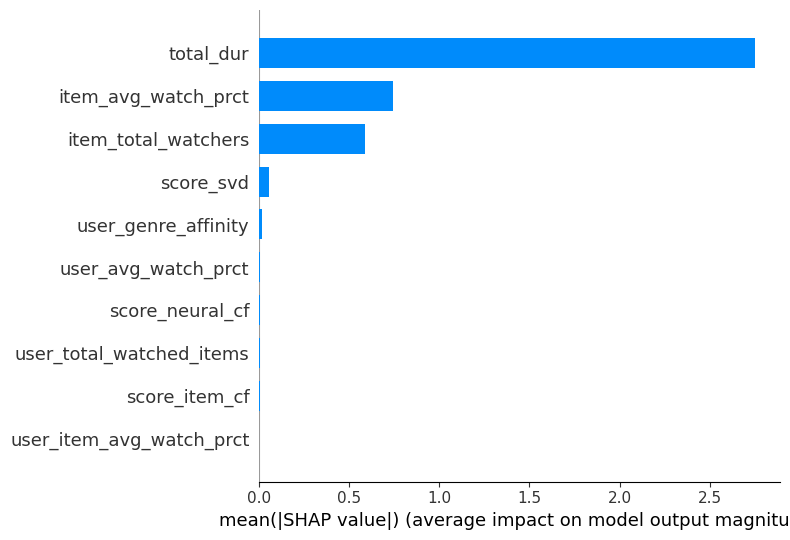

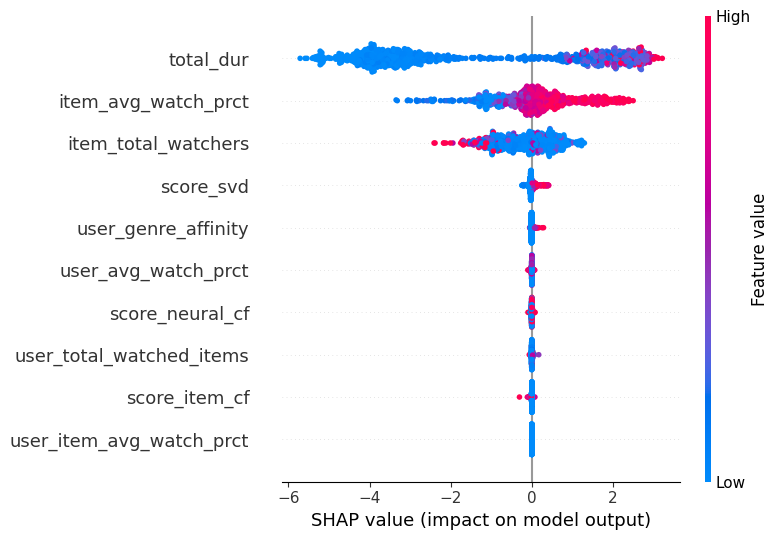

In [51]:
# SHAP-анализ 
explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(X_train.iloc[:1000])

# Визуализация SHAP
shap.summary_plot(shap_values, X_train.iloc[:1000], plot_type="bar")
shap.summary_plot(shap_values, X_train.iloc[:1000])

тут также самые важные признаки теже, что были ранее

In [52]:
# проверим на ROC-AUC
xgb_class = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)

xgb_class.fit(X_train, y_train)
pred_class = xgb_class.predict_proba(X_test)[:, 1]
print("ROC-AUC классификация:", roc_auc_score(y_test, pred_class))


ROC-AUC классификация: 0.9810083213638461


In [53]:
# Ranker
groups = train_df_scores.groupby('user_id').size().values
xgb_rank = xgb.XGBRanker(objective='rank:pairwise', eval_metric='auc', random_state=42)
xgb_rank.fit(X_train, y_train, group=groups)
pred_rank = xgb_rank.predict(X_test)
print("ROC-AUC ранжирование:", roc_auc_score(y_test, pred_rank))

ROC-AUC ранжирование: 0.9822472357839094


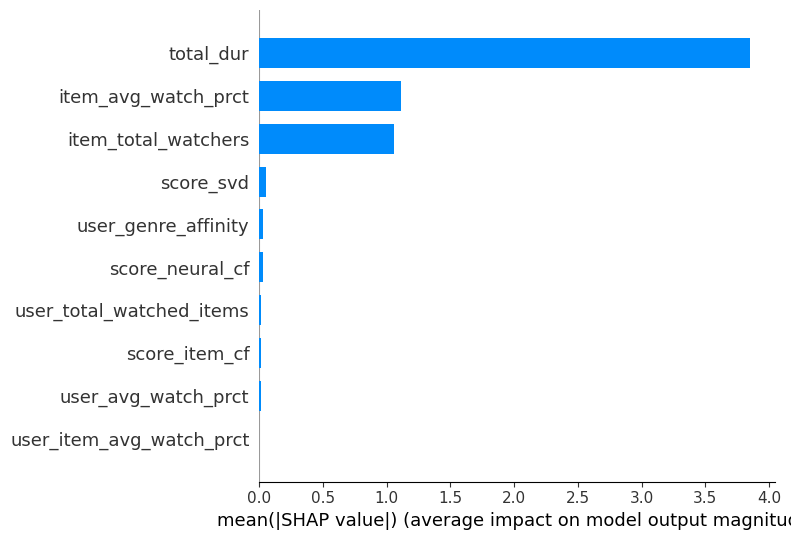

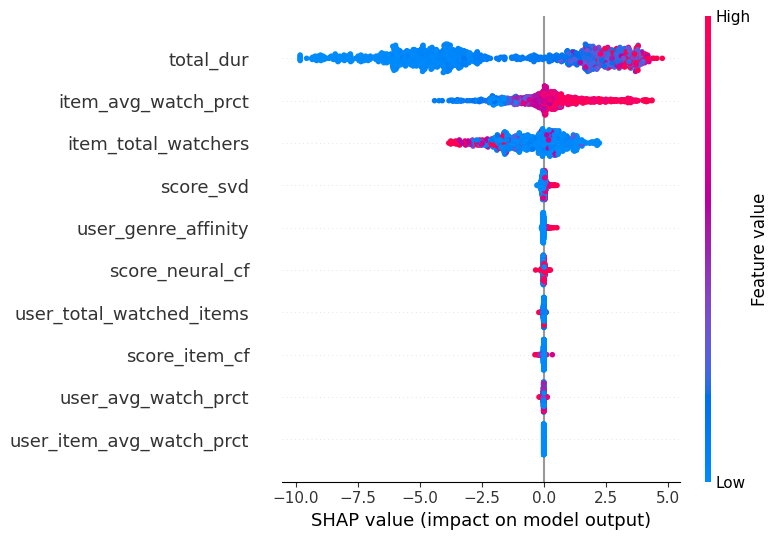

In [54]:
# SHAP-анализ 
explainer = shap.TreeExplainer(xgb_rank)
shap_values = explainer.shap_values(X_train.iloc[:1000])  
# Визуализация SHAP
shap.summary_plot(shap_values, X_train.iloc[:1000], plot_type="bar")
shap.summary_plot(shap_values, X_train.iloc[:1000])

In [55]:
# Обработка холодных пользователей (если нужно)
cold_users_mask = test_df_scores['user_id'].isin(train_df_scores['user_id'])
if cold_users_mask.any():
    print(f"Холодных пользователей: {cold_users_mask.sum()}")

Холодных пользователей: 343709



### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

In [56]:
# Объединяем train и test данные
data_full = pd.concat([df_train, df_test], axis=0)

In [57]:
# на SVD
my_matrix_factorization = SVD(n_components=100)
my_matrix_factorization.fit(data_full)

In [58]:
#  на ItemCF
my_heuristic_model = ItemCF(top_k=50, min_similarity=0.1)
my_heuristic_model.fit(data_full)

In [59]:
# на NCF
uni_users = data_full['user_id'].unique()
uni_items = data_full['item_id'].unique()
my_neural_network = train_ncf(data_full, num_users=len(uni_users), num_items=len(uni_items), epochs=6, lr=0.01)

Epoch 1/6, Loss: 0.688
Epoch 2/6, Loss: 0.685
Epoch 3/6, Loss: 0.681
Epoch 4/6, Loss: 0.678
Epoch 5/6, Loss: 0.676
Epoch 6/6, Loss: 0.674


In [69]:
# Генерация кандидатов от каждой модели
def generate_people(user_id, models, N=50):
    candidates = defaultdict(dict)
    
    # ItemCF
    cf_items = models['item_cf'].recommend(user_id, k=N)
    for item in cf_items:
        candidates[item]['item_cf_score'] = models['item_cf'].predict(user_id, item)

    # SVD
    svd_items = models['svd'].recommend(user_id, k=N)
    for item in svd_items:
        candidates[item]['svd_score'] = models['svd'].predict(user_id, item)
    
    # NCF
    ncf_items = models['ncf'].recommend(user_id, k=N)
    for item in ncf_items:
        candidates[item]['ncf_score'] = models['ncf'].predict(user_id, item)
    
    return candidates

In [71]:
# Генерация кандидатов по выборке до 1к челов, делаю это в 22:50 по МСК
all_users = data_full['user_id'].unique()
user_candidates = {}
models = {
    'item_cf': my_heuristic_model,
    'svd': my_matrix_factorization,
    'ncf': my_neural_network
}

for user in all_users[:1000]: 
    user_candidates[user] = generate_people(user, models, N=50)

In [74]:
# Объединение кандидатов и скоров
all_candidates = {}
for user in user_candidates:
    if isinstance(user_candidates[user], dict):
        items_scores = []
        for item, scores in user_candidates[user].items():
            for model in ['item_cf', 'svd', 'ncf']:
                if model not in scores:
                    model_scores = [v[model] for k, v in user_candidates[user].items() if model in v]
                    scores[model] = np.mean(model_scores) if model_scores else 0
            items_scores.append((item, scores))
        all_candidates[user] = items_scores
    else:
        all_candidates[user] = []


In [ ]:
# Сбор фичей для кандидатов
def generate_features(user_id, item_id):
    features = {}
    
    # User features
    user_data = data_full[data_full['user_id'] == user_id].iloc[0]
    features.update({
        'user_age': user_data.get('age', 0),
        'user_gender': user_data.get('gender', 0),
        'user_avg_watch': data_full[data_full['user_id'] == user_id]['watched_pct'].mean()
    })

    item_data = data_full[data_full['item_id'] == item_id].iloc[0]
    features.update({
        'item_genre': hash(item_data.get('genre', '')) % 1000,
        'item_year': item_data.get('year', 0),
        'item_avg_watch': data_full[data_full['item_id'] == item_id]['watched_pct'].mean()
    })
    
    user_item_data = data_full[(data_full['user_id'] == user_id) & (data_full['item_id'] == item_id)]
    if not user_item_data.empty:
        features['last_watch_pct'] = user_item_data.iloc[0]['watched_pct']
    else:
        features['last_watch_pct'] = 0
    
    return features

candidate_features = {}
for user in list(all_candidates.keys())[:1000]: 
    for item, _ in all_candidates[user]:
        candidate_features[(user, item)] = generate_features(user, item)

Сделал, что успел, в целом, домашка интересная, но очень трудная (особенно для тех, кто сталикается с таким в первый раз).
Спасибо авторам курса и данной домашки, лекторам и проверяющим.

Согласно нашим показателям, модели наичнают обучаться, лос падает и приближается к оптимому, для более глубоко исследования не хватает ресурсов и времени.
Самыми важными признаками оказались: total_dur, item_total_watchers, item_avg_watch_prct (по графикам можем наглядно видеть зависиомсти)
